# Training classifiers from folders of images

When training pixel classifiers, utilizing multiple images becomes crucial, especially in scenarios where images exhibit variations, particularly across different conditions (i.e. in this case before or after sonication). It is essential to train classifiers using a diverse set of images representing all relevant conditions for optimal performance.

In this notebook we train [APOC](https://github.com/haesleinhuepf/apoc) classifiers using two folders containing pairs of training data.

In [4]:
from pathlib import Path
import apoc
import os
import matplotlib.pyplot as plt
import tifffile

## Data preparation
We start by selecting two input folders. One with images, and one with sparsely annotated label images (masks). The names of the files in that folder must be pairwise identical.

In [5]:
# Define input folders
image_folder = Path("./data/biofilm_train/images/")
masks_folder = Path("./data/biofilm_train/masks/")

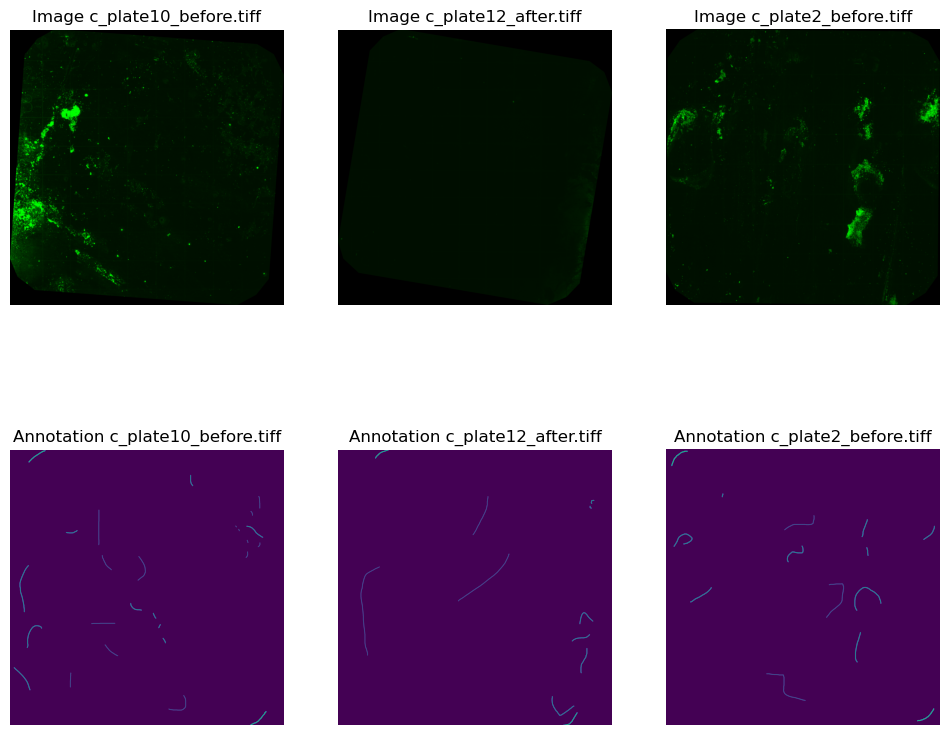

In [10]:
# Get the list of file names in the images and masks folder
image_file_list = [file_path.name for file_path in image_folder.glob("*.tiff")]
masks_file_list = [file_path.name for file_path in masks_folder.glob("*.tiff")]

# Ensure the masks folder has the same number of files as the images folder
assert len(image_file_list) == len(masks_file_list), "Number of images and masks must be the same."

# Show images and corresponding masks side by side
num_images = len(image_file_list)
fig, axs = plt.subplots(2, num_images, figsize=(4 * num_images, 10))

for i, (image_filename, mask_filename) in enumerate(zip(image_file_list, masks_file_list)):
    # Plot the image
    image = tifffile.imread(os.path.join(image_folder, image_filename))
    axs[0, i].imshow(image)
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Image {image_filename}")

    # Plot the corresponding mask
    mask = tifffile.imread(os.path.join(masks_folder, mask_filename))
    axs[1, i].imshow(mask, cmap="viridis")  # Use cmap='viridis' for multinary masks
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Annotation {mask_filename}")
    
plt.show()


Transform RGB images into grayscale uint8 to be fed into the APOC classifier and reduce training time

In [84]:
# Define output directory for renamed annotations
processed_images = "./data/biofilm_train/grayscale/images"

# Check if the output folder exists, create it if not
try:
    os.makedirs(processed_images)
    print(f"Output folder created: {processed_images}")
except FileExistsError:
    print(f"Output folder already exists: {processed_images}")

for image in image_file_list:
    rgb_image = tifffile.imread(os.path.join(image_folder, image), is_ome=False)
    grayscale_image = rgb_image[:,:,1]
    grayscale_image = grayscale_image.astype("uint8")
    tifffile.imwrite(os.path.join(processed_images, image), grayscale_image, dtype="uint8")

Output folder already exists: ./data/biofilm_train/grayscale/images


## Training
If the folders are setup properly, we can pass the folders to the training.

In [14]:
# Setup classifer and where it should be saved
cl_filename = "./pretrained_classifiers/semantic_segmenter.cl"
apoc.erase_classifier(cl_filename)
segmenter = apoc.PixelClassifier(opencl_filename=cl_filename)

# Setup feature set used for training
features = apoc.PredefinedFeatureSet.object_size_1_to_5_px.value #TODO: Check

# Train classifier on folders
apoc.train_classifier_from_image_folders(
    segmenter, 
    features, 
    image = processed_images, # Grayscale processed images, no RGB
    ground_truth = masks_folder)

## Prediction
After the training, we can apply the classifier to all images in the image folder. The following line reloads the classifier from disk. In that way we can ensure that it was stored correctly.

In [15]:
cl_filename = "./pretrained_classifiers/semantic_segmenter.cl"
segmenter = apoc.PixelClassifier(opencl_filename=cl_filename)

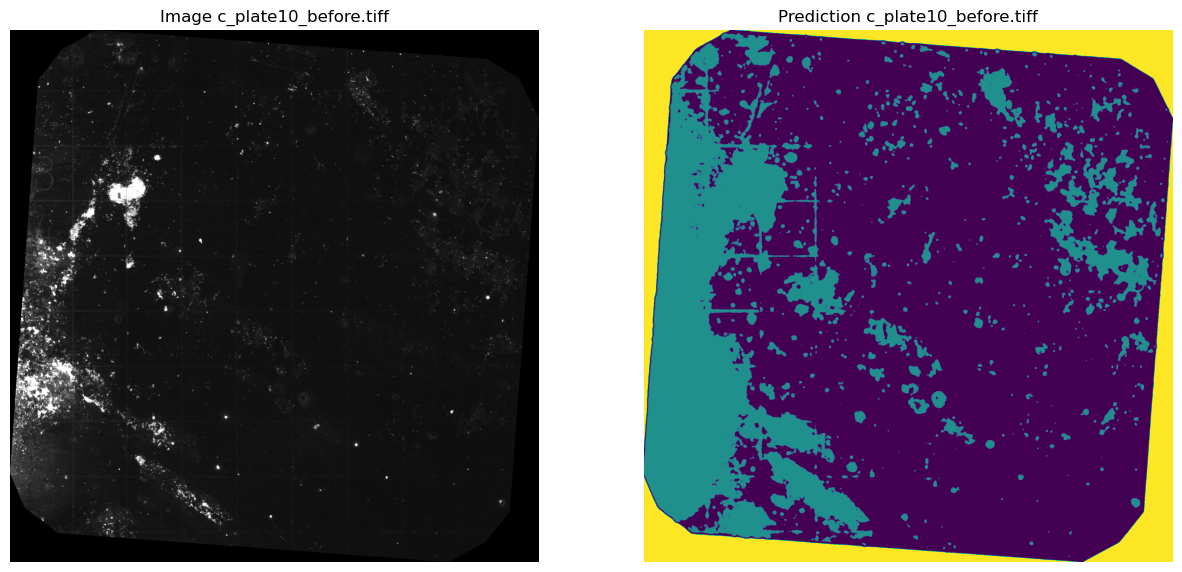

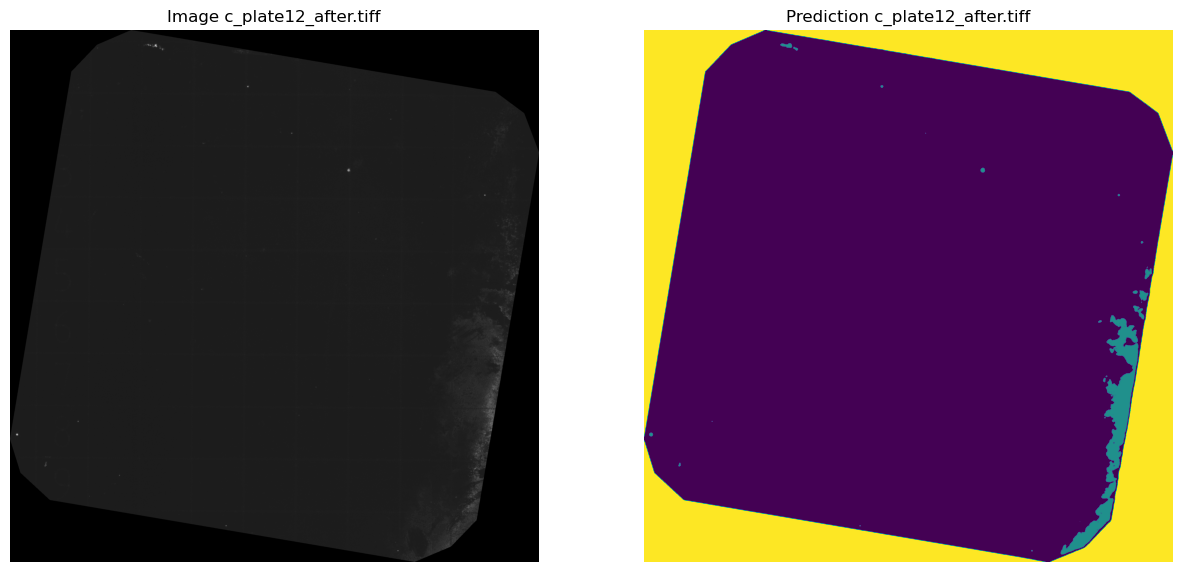

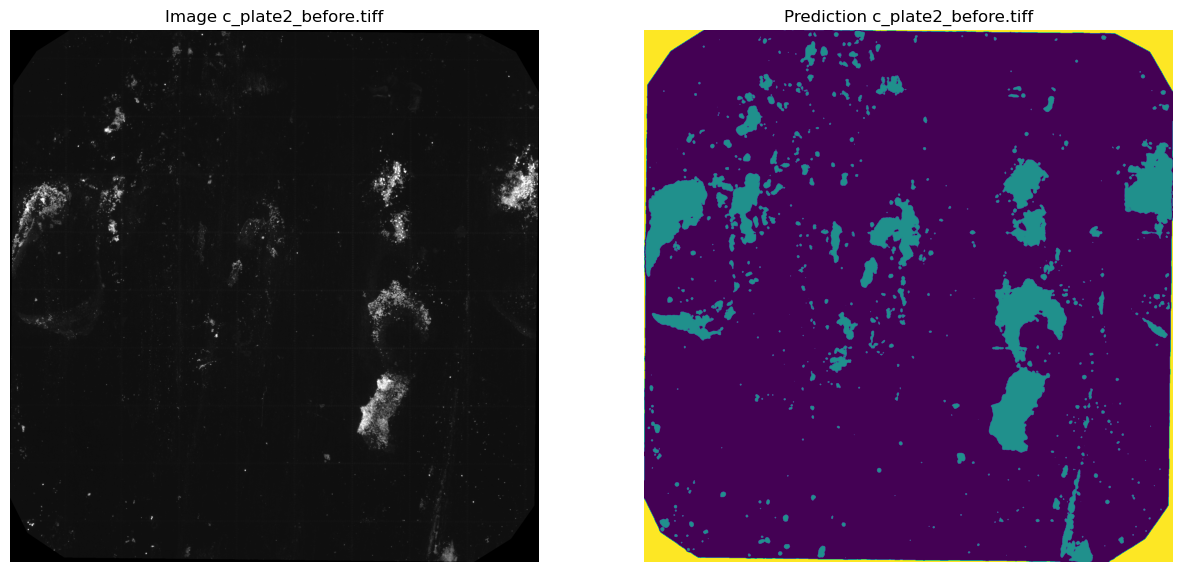

In [16]:
processed_images = Path("./data/biofilm_train/grayscale/images")
grayscale_image_file_list = [file_path.name for file_path in processed_images.glob("*.tiff")]

# Plot input images and predicted masks side by side
for i, image_filename in enumerate(grayscale_image_file_list):
    
    fig, axs = plt.subplots(1, 2, figsize=(15,15))
    
    image = tifffile.imread(os.path.join(processed_images, image_filename), is_ome=False)
    axs[0].imshow(image, cmap="gray")
    axs[0].axis("off")
    axs[0].set_title(f"Image {image_filename}")
    
    predicted_labels = segmenter.predict(image)
    axs[1].imshow(predicted_labels, cmap='viridis')  # Use cmap='viridis' for multinary masks
    axs[1].axis("off")
    axs[1].set_title(f"Prediction {image_filename}")
    
    plt.show()